In [1]:
city_name = 'Reims' # just for saving the file
metric_projection = 'EPSG:27563' # search for a valid metric projection code for your city
timezone = 'Europe/Paris'

In [2]:
# # check if timezone exists
assert timezone in __import__('pytz').all_timezones, "Set correct Timezone"

# IMPORT THE AOI

But for better customization I suggest using geojson.io

In [ ]:
import geomob
from synth_gps.utils import get_and_save_bbox

AOI = f'aoi_{city_name}.geojson'

# retrieve the data (according to OSM api policy, you should provide your email)
city_shape = geomob.retrieve_osm(city_name, "SynthGPS Downloader (yourmailhere)").loc[[0]]
get_and_save_bbox(city_shape, AOI)

# GET DATA FROM OVERTURE AND GOOGLE EE

Here a Spark Session will be set. 
If you have less cores reduce them to the appropriate amount to avoid freezing.

In [6]:
from synth_gps.utils import load_resources, get_tiles_wph
import numpy as np

OVERTURE = 'overture_s3_urls.json'

resources = load_resources(n_cores=10, aoi_path=AOI, resources_path=OVERTURE)
pv, rv, bv, aoi = resources['POIS'], resources['ROADS'], resources['BUILDINGS'], resources['AOI']
bbox_tess = get_tiles_wph(aoi, metric_projection)

:: loading settings :: url = jar:file:/home/ludovico/geo_venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.sedona#sedona-spark-3.4_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e6f5a096-0173-4b38-998f-e3381b72da9d;1.0
	confs: [default]
	found org.apache.sedona#sedona-spark-3.4_2.12;1.6.0 in central
	found org.apache.sedona#sedona-common;1.6.0 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found org.locationtech.jts#jts-core;1.19.0 in central
	found org.wololo#jts2geojson;0.16.1 in central
	found org.locationtech.spatial4j#spatial4j;0.8 in central
	found com.google.geometry#s2-geometry;2.0.0 in central
	found com.google.guava#guava;25.1-jre in central
	found com.google.code.findbugs#jsr305;3.0.2 in central
	found org.checkerframework#checker-qual;2.0.0 in central
	found com.google.errorprone#error_prone_annotations;2.1.3 in central
	found com.google.j2objc#j2objc-ann

# PROCESS BUILDINGS

<Axes: >

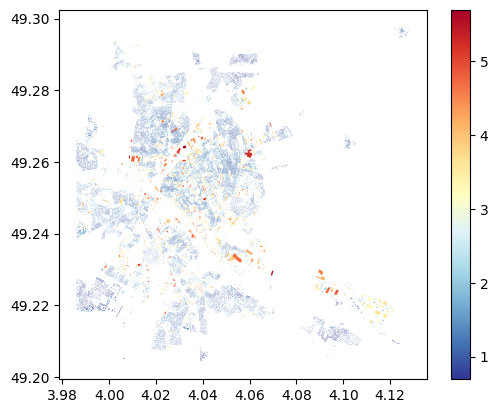

In [7]:
from synth_gps.building import BuildingProcessor, point_filling_geometries
from synth_gps.metadata import generate_uids

bv_inhabitants = BuildingProcessor(bv, metric_projection).get_default_features(bbox_tess)
home_locations = point_filling_geometries(bv_inhabitants, n_point_feature = 'inhabitants')
home_locations['uid'] = generate_uids(len(home_locations))

bv_inhabitants.assign(log_inhabitants = np.log(bv_inhabitants['inhabitants'] + 1))\
              .plot('log_inhabitants', cmap = 'RdYlBu_r', legend = True)

# PREPROCESS ROADS

In [8]:
from synth_gps.roads import RoadProcessor

roads_pipeline = RoadProcessor(rv, metric_projection)

rv = roads_pipeline.roads
G = roads_pipeline.get_graph()

# PROCESS POIs

In [9]:
from synth_gps.pois import POIsProcessor

poi_pipeline = POIsProcessor(pv, metric_projection)
poi_pipeline.add_building_area(bv)

poi_pipeline.get_poi_centrality()
poi_pipeline.get_poi_importance()

poi_igraph = poi_pipeline.poi_igraph
edge_geoms = poi_pipeline.edge_geoms
pv_processed = poi_pipeline.pois

print(len(poi_igraph.components()), 'components')
print(len(edge_geoms), 'edges')

17 components
16850 edges


Text(0.5, 1.0, 'POIs centrality')

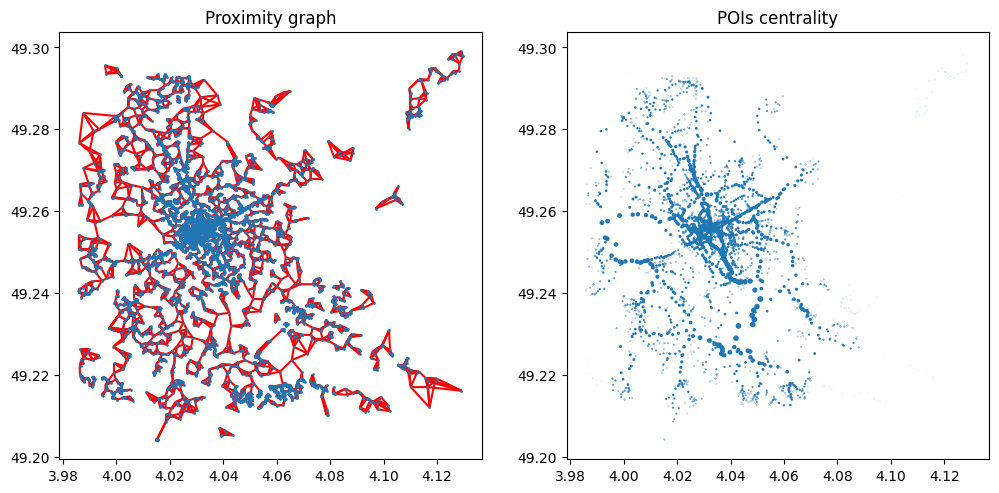

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

edge_geoms.plot(ax = axs[0], zorder = 1, color='red')
pv_processed.plot(markersize=1, ax = axs[0], zorder = 2)
axs[0].set_title('Proximity graph')
pv_processed.plot(markersize=pv_processed['centrality'] * 10 / pv_processed['centrality'].max(), ax = axs[1])
axs[1].set_title('POIs centrality')

# COMPUTE OD

In [ ]:
from synth_gps.od import odGenerator
import geopandas as gpd

home_locations_reprojected = home_locations.to_crs(metric_projection)
pv_reprojected = pv_processed.to_crs(metric_projection)
road_nodes = gpd.GeoDataFrame(geometry = G.vs['geometry'], crs = metric_projection)

# in many large cities it is necessary to sample the OD pairs to avoid using too much memory
od_gen = odGenerator(home_locations_reprojected, pv_reprojected, road_nodes)

for _ in range(1):
    od_gen.generate_OD_pairs(kind = 'origins')
    
computational_OD = od_gen.get_computable_OD(which_destination='all')
computed_paths = od_gen.get_paths(G, computational_OD)
trips = od_gen.assign_paths_to_OD(od_gen.od_pairs, computed_paths)
trips['uid'] = trips.index.map(dict(enumerate(od_gen.uids)))

In [97]:
from geomob import plot_gdf
agg_trips = od_gen.get_trips_with_size(which_destination = 'D', sample = 0.01) # just for visualization
plot_gdf(agg_trips)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'plot_gdf':              flows       olat      olng       dlat      dlng  delta_space
O     D  …

# ASSIGN OCCUPANCY TO ROADS

In [98]:
occupancy_dict = dict(zip(*np.unique(np.concatenate(trips['edge'].values), return_counts=True)))
rv['occupancy'] = rv.index.map(occupancy_dict).fillna(0).astype(int)

# COMPUTING MOVING PINGS

The synthetic GPS data generator proceeds first by generating random points on buildings and roads.
Then it assigns the points by fitting lines according to the user paths and the user expected ping density.

Every random distribution used is approximately a power-law.
Thus the output is similar to what someone can expect from a typical real dataset.

Reduce the AOI size or the pings per user to speed up the computation.

nb. I may optimize it in the future

In [ ]:
from synth_gps.metadata import SynthGPS

meters_road_buffer = 5
max_pings_per_user = 100
max_days = 1
hour_range = (0, 24)

nodes = gpd.GeoDataFrame(geometry= G.vs['geometry'], crs = metric_projection)
synthetic_generator = SynthGPS(rv, meters_road_buffer, metric_projection, max_pings_per_user)
synthetic_generator.set_time(max_days, hour_range)

In [123]:
generated = synthetic_generator.generate_moving_pings(trips, 
                                                        noise_strength = 100, filter_speed = 200, 
                                                        timezone = 'Europe/Paris', get_metrics = False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 162514/162514 [00:30<00:00, 5292.54it/s]


In [125]:
plot_gdf(generated)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'plot_gdf':        space_delta time_delta       speed                            uid  \
0      …